# README
SVM and Feedforward neural networks are tried on the PCA (principal components analysis) dataset, with the PCA fitted from the **base** dataset. PCA is generated from the image-only repository (`conjunct/rps_raw`).

Components required are summarized in this table:

Variance explained | Components required
------------------ | -------------------
99.9%              | 1580               
99%                | 653                
97.5%              | 369                
95%                | 213                
90%                | 106      


The model discussed in the paper is noted in the code. Along with other models not in the paper, SVM (PCA) Base is attempted in this file.

# Setup

In [ ]:
%%capture
!pip install datasets

In [ ]:
from datasets import load_dataset
#mediapipe dependencies

#torch dependencies
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, ResNetForImageClassification
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import torchvision
import torch

#general dependencies
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import shutil
import os
from tqdm import tqdm

import time
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting tool

### Utilities

In [ ]:
# Stringify a numeric label into textual form
def decode_label(label):
    if label == 1:
        return "rock"
    elif label == 0:
        return "paper"
    elif label == 2:
        return "scissors"
    elif label == 3:
        return "none"
    return None
    # return "rock" if label == 1 else "paper" if label == 0 else "scissors"

# grey scale images (channel 1)
def grey_scale():
  transform = transforms.Compose([
      transforms.Resize(256),
      transforms.Grayscale(num_output_channels=1),
  ])
  return transform

# returns a transformed image of shape (300, 300, 3)
def rgb_image_transform(image): # input type PIL.PngImagePlugin.PngImageFile
  resized_image = image.resize((300, 300))
  if resized_image.mode != 'RGB':
    resized_image = resized_image.convert('RGB')

  return resized_image

# returns a numpy (tensor) of an image
def image_numpy(image):
  np_image = np.array(image)

  return np_image


In [ ]:
toImage = transforms.Compose([
    transforms.ToPILImage(),
])

In [ ]:
def reconstitute(pca, npdata, num_components):
    # global pca_4883
    # pca = pca_4883
    val = np.dot(npdata[:num_components], pca.components_[:num_components]) # * std_dev + mean
    # val = val * std_dev + mean
    valn = np.clip(np.round(val * std_dev + mean), 0, 255).astype(np.uint8)
    # print(valn)
    img = toImage(valn.reshape((256, 256, 1)))
    return img


In [ ]:
raw_ds = load_dataset("conjunct/rps_raw")

Generating train split:   0%|          | 0/9170 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2035 [00:00<?, ? examples/s]

In [ ]:
base_ds = raw_ds.filter(lambda x: x['src'] == 0)

Filter:   0%|          | 0/9170 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2035 [00:00<?, ? examples/s]

# Run PCA (base)

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256), # (32, 256)),

    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=1),
    # transforms.RandomInvert(p=1),
    transforms.PILToTensor(),

])

Note: memory-mapped arrays are used to circumvent problems with running out of RAM with PCA.

```
# Delete the memmap instance to close the file (this does not delete the data on disk)
del mmapped_array

# When you want to read the array from disk
mmapped_array = np.memmap('mmapped_array.dat', dtype='float32', mode='r', shape=shape)
```

In [ ]:
import numpy as np
import os

# Define the shape of the array based on your data
shape = (len(base_ds['train']), 65536)

# Create a memory-mapped array with the desired shape
mmapped_array = np.memmap('mmapped_array.dat', dtype='float32', mode='w+', shape=shape)

# Flatten and write tensors to the memory-mapped array
for i, tensor in enumerate(base_ds['train']['image']):
    mmapped_array[i] = transform(tensor).flatten()

In [ ]:
# Define the shape of the array based on your data
shape = (len(base_ds['test']), 65536)

# Create a memory-mapped array with the desired shape
mmapped_array_test = np.memmap('mmapped_array_test.dat', dtype='float32', mode='w+', shape=shape)

# Flatten and write tensors to the memory-mapped array
for i, tensor in enumerate(base_ds['test']['image']):
    mmapped_array_test[i] = transform(tensor).flatten()

In [ ]:
mean = np.mean(mmapped_array, axis=0)
std_dev = np.std(mmapped_array, axis=0)

In [ ]:

# # Create a memory-mapped array for the standardized data
# standardized_mmap_test = np.memmap('standardized_mmap_test.dat', dtype='float32', mode='w+', shape=shape)


# # Standardize the data in chunks to avoid running out of memory
# chunk_size = 1000  # Adjust this value based on your available memory
# num_chunks = len(mmapped_array_test) // chunk_size

# for i in range(num_chunks):
#     chunk = mmapped_array_test[i*chunk_size:(i+1)*chunk_size]
#     standardized_mmap_test[i*chunk_size:(i+1)*chunk_size] = (chunk - mean) / std_dev

# # Don't forget to handle the last chunk if it's smaller than chunk_size
# if len(mmapped_array_test) % chunk_size != 0:
#     chunk = mmapped_array_test[num_chunks*chunk_size:]
#     standardized_mmap_test[num_chunks*chunk_size:] = (chunk - mean) / std_dev

# # Delete the memmap instances to close the files (this does not delete the data on disk)
# del standardized_mmap_test

# # When you want to read the arrays from disk
# standardized_mmap_test = np.memmap('standardized_mmap_test.dat', dtype='float32', mode='r', shape=shape)

In [ ]:
# Create a memory-mapped array for the standardized data



def pca_standardize(mmap_from: np.ndarray, mmap_to: np.ndarray):
    # Standardize the data in chunks to avoid running out of memory
    chunk_size = 1000  # Adjust this value based on your available memory
    num_chunks = len(mmap_from) // chunk_size

    for i in range(num_chunks):
        chunk = mmap_from[i*chunk_size:(i+1)*chunk_size]
        mmap_to[i*chunk_size:(i+1)*chunk_size] = (chunk - mean) / std_dev

    # Don't forget to handle the last chunk if it's smaller than chunk_size
    if len(mmap_from) % chunk_size != 0:
        chunk = mmap_from[num_chunks*chunk_size:]
        mmap_to[num_chunks*chunk_size:] = (chunk - mean) / std_dev

In [ ]:
standardized_mmap = np.memmap('standardized_mmap.dat', dtype='float32', mode='w+', shape=mmapped_array.shape)
pca_standardize(mmapped_array, standardized_mmap)

In [ ]:
standardized_mmap_test = np.memmap('standardized_mmap_test.dat', dtype='float32', mode='w+', shape=mmapped_array_test.shape)
pca_standardize(mmapped_array_test, standardized_mmap_test)

In [ ]:
!ls -lh

total 1.5G
-rw-r--r-- 1 root root 630M Apr 22 21:42 mmapped_array.dat
-rw-r--r-- 1 root root  93M Apr 22 21:42 mmapped_array_test.dat
drwxr-xr-x 1 root root 4.0K Apr 19 13:30 sample_data
-rw-r--r-- 1 root root 630M Apr 22 21:43 standardized_mmap.dat
-rw-r--r-- 1 root root  93M Apr 22 21:44 standardized_mmap_test.dat


0.9 variance explained at 106 components
0.95 variance explained at 213 components
0.975 variance explained at 369 components
0.99 variance explained at 653 components
0.999 variance explained at 1580 components


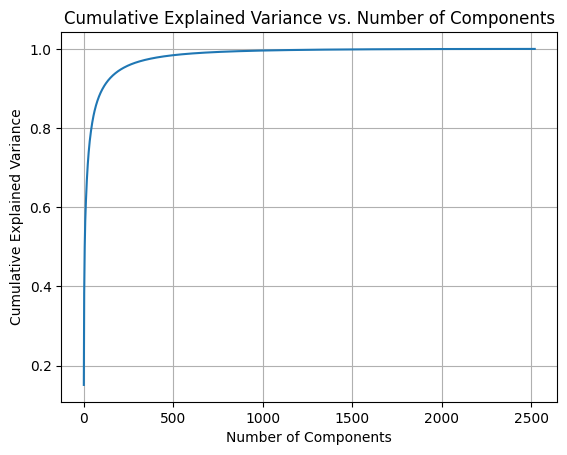

Time for 4883 (CPU): 114.33932161331177


In [ ]:
import time
start = time.time()

# Create PCA object
pca = PCA()

# Fit PCA on your data
pca.fit(standardized_mmap)

# Plot cumulative variance explained
axis = np.cumsum(pca.explained_variance_ratio_)
found = 0
for i in range(len(axis)):
  if found == 0 and axis[i] > 0.9:
    print(f'0.9 variance explained at {i} components')
    found += 1
  if found == 1 and axis[i] > 0.95:
    print(f'0.95 variance explained at {i} components')
    found += 1
  if found == 2 and axis[i] > 0.975:
    print(f'0.975 variance explained at {i} components')
    found += 1
  if found == 3 and axis[i] > 0.99:
    print(f'0.99 variance explained at {i} components')
    found += 1
  if found == 4 and axis[i] > 0.999:
    print(f'0.999 variance explained at {i} components')
    found += 1

plt.plot(axis)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

end = time.time()
print("Time for full PCA (CPU):", end - start)

It took 114 seconds to fit PCA

In [ ]:
!ls -lh

total 1.5G
-rw-r--r-- 1 root root 630M Apr 22 21:42 mmapped_array.dat
-rw-r--r-- 1 root root  93M Apr 22 21:42 mmapped_array_test.dat
drwxr-xr-x 1 root root 4.0K Apr 19 13:30 sample_data
-rw-r--r-- 1 root root 630M Apr 22 21:43 standardized_mmap.dat
-rw-r--r-- 1 root root  93M Apr 22 21:44 standardized_mmap_test.dat


In [ ]:
pca_1580 = PCA(n_components=1580).fit(standardized_mmap)

In [ ]:
pca_1580.components_ = pca_1580.components_.astype(np.float16)

In [ ]:
import time
start = time.time()
# pca.n_components = 1580
transformed_data_1580 = pca_1580.transform(standardized_mmap)
end = time.time()
print("Inference time for 1583:", end - start)


Inference time for 1583: 13.327266216278076


In [ ]:
start = time.time()
# pca.n_components = 1580
transformed_data_1580_test = pca_1580.transform(standardized_mmap_test)
end = time.time()
print("Time for 1583:", end - start)

Time for 1583: 2.6711788177490234


In [ ]:
# save 1580 PCA
import pickle as pk
with open("pca_1580.pkl","wb") as f:
    pk.dump(pca_1580, f)

In [ ]:
!cp pca_1580.pkl pca_save.pkl

In [ ]:
# load 1580 PCA
import pickle as pk
with open("pca_1580.pkl","rb") as f:
    pca_1580 = pk.load(f)

In [ ]:
!ls -lh

total 2.0G
-rw-r--r-- 1 root root 630M Apr 22 21:59 mmapped_array.dat
-rw-r--r-- 1 root root  93M Apr 22 21:59 mmapped_array_test.dat
-rw-r--r-- 1 root root 198M Apr 22 22:08 pca_1580.pkl
-rw-r--r-- 1 root root 397M Apr 22 21:56 pca_1583.pkl
drwxr-xr-x 1 root root 4.0K Apr 19 13:30 sample_data
-rw-r--r-- 1 root root 630M Apr 22 21:59 standardized_mmap.dat
-rw-r--r-- 1 root root  93M Apr 22 21:59 standardized_mmap_test.dat


In [ ]:
transformed_data_1580[0]

array([ 4.5929916e+01,  4.7899357e+01,  8.5443695e+01, ...,
        7.8342110e-04, -4.8618764e-05,  2.4583191e-04], dtype=float32)

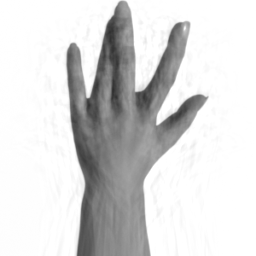

In [ ]:
# show that float16 does not result in any decrease in quality in comparison to float32
# original pca
reconstitute(pca, transformed_data_1580[0], 500)

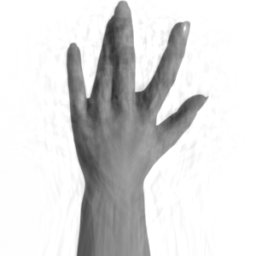

In [ ]:
# float16 pca
reconstitute(pca_1580, transformed_data_1580[0], 500)

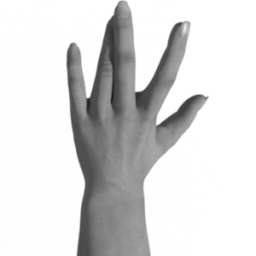

In [ ]:
# _pt_invert =

toImage(transform(base_ds['train'][0]['image']))

# Examining the data

Try PCA on kaggle dataset

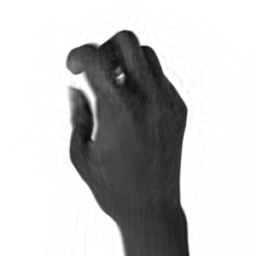

In [ ]:
sample = pca.transform(((transform(raw_ds['train'][1000]['image'])).reshape(1, 65536) - mean) / std_dev).flatten()
# float16 pca
reconstitute(pca, sample, 1000)

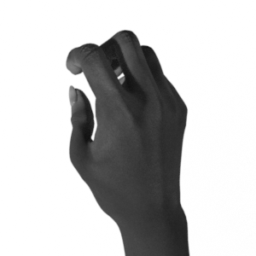

In [ ]:
toImage(transform(raw_ds['train'][1000]['image']))

slightly out-of-domain image!

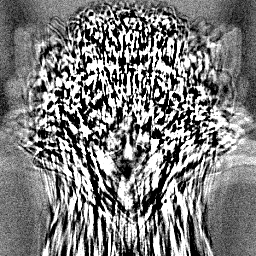

In [ ]:
sample = pca.transform(((transform(raw_ds['train'][4000]['image'])).reshape(1, 65536) - mean) / std_dev).flatten()
# float16 pca
reconstitute(pca, sample, 1000)

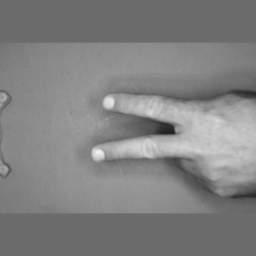

In [ ]:
toImage(transform(raw_ds['train'][4000]['image']))

Try lowres

In [ ]:
orig_components = pca_4883.components_

In [ ]:
comp_lowres = orig_components.astype(np.float16)

In [ ]:
pca_4883.components_ = comp_lowres

In [ ]:
with open("pca_lowres.pkl", 'wb') as f:
    pk.dump(pca_4883, f)

In [ ]:
!ls -lh

total 9.7G
-rw-r--r-- 1 root root 2.3G Apr 21 04:36 mmapped_array.dat
-rw-r--r-- 1 root root 509M Apr 21 05:24 mmapped_array_test.dat
-rw-r--r-- 1 root root 1.2G Apr 21 05:01 pca_4883.pkl
-rw-r--r-- 1 root root 611M Apr 21 06:10 pca_lowres.pkl
-rw-r--r-- 1 root root 1.2G Apr 21 05:01 pca_save.pkl
drwxr-xr-x 1 root root 4.0K Apr 18 13:25 sample_data
-rw-r--r-- 1 root root 2.3G Apr 21 04:38 standardized_mmap.dat
-rw-r--r-- 1 root root 509M Apr 21 05:29 standardized_mmap_test.dat
-rw-r--r-- 1 root root 1.2G Apr 21 05:42 weights.npy


In [ ]:
from google.colab import files
files.download('pca_lowres.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# SVM

Prerequisites: pca_1580, transformed_data_1580

Train SVM on all 1580

In [ ]:
def pca_train_svm(num_components):

    start = time.time()
    end = time.time()
    print(f'PCA time: {end - start}')

    X_train = transformed_data_1580[:, :num_components]
    X_test = transformed_data_1580_test[:, :num_components]
    y_train = base_ds['train']['label']
    y_test = base_ds['test']['label']

    # train_test_split(transformed_data_base_set, ds_shuffled['train']['label'], test_size=0.2, random_state=42)

    # # Create and train the SVM classifier
    svm_classifier = SVC(kernel='rbf')
    start = time.time()
    svm_classifier.fit(X_train,y_train)
    end = time.time()
    y_pred = svm_classifier.predict(X_test)

    print(f"Time: {end - start}")
    # # Evaluate the classifier
    print(f"{num_components} components")
    print("Accuracy on test set:", accuracy_score(y_test, y_pred))
    print("Classification report:")
    print(classification_report(y_test, y_pred))

    pca_for_plotting = PCA(n_components=2)
    X_train_2d = pca_for_plotting.fit_transform(X_train)


    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, alpha=0.5)
    plt.title("SVM Classification (2D Projection)")
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()


    return svm_classifier

Variance explained:

Variance explained | Components required
------------------ | -------------------
99.9%              | 1580               
99%                | 653                
97.5%              | 369                
95%                | 213                
90%                | 106                

PCA time: 2.384185791015625e-07
Time: 2.588002920150757
1580 components
Accuracy on test set: 0.6317204301075269
Classification report:
              precision    recall  f1-score   support

           0       0.58      0.55      0.56       124
           1       0.79      0.52      0.63       124
           2       0.59      0.82      0.69       124

    accuracy                           0.63       372
   macro avg       0.65      0.63      0.63       372
weighted avg       0.65      0.63      0.63       372



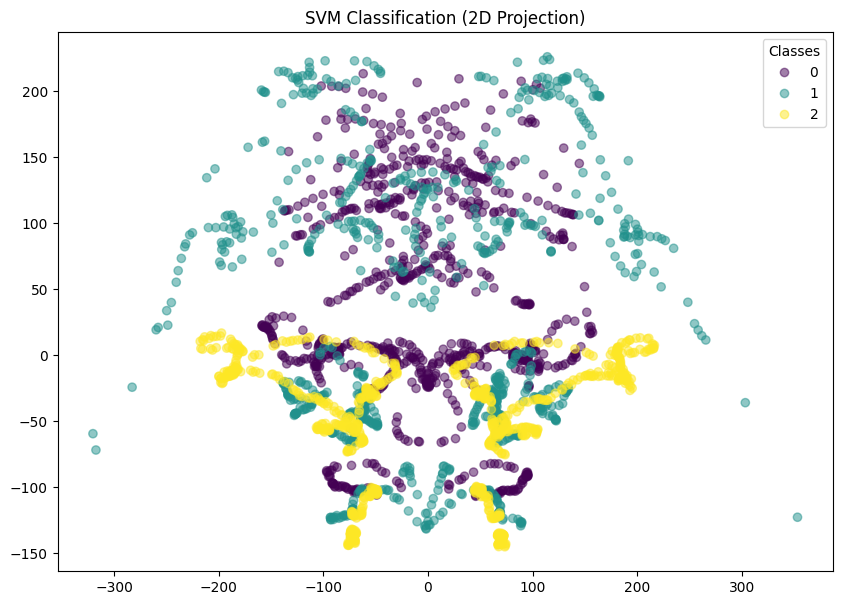

In [ ]:
svm = pca_train_svm(1580)

PCA time: 4.76837158203125e-07
Time: 1.6102750301361084
653 components
Accuracy on test set: 0.6344086021505376
Classification report:
              precision    recall  f1-score   support

           0       0.58      0.55      0.56       124
           1       0.80      0.52      0.63       124
           2       0.59      0.83      0.69       124

    accuracy                           0.63       372
   macro avg       0.66      0.63      0.63       372
weighted avg       0.66      0.63      0.63       372



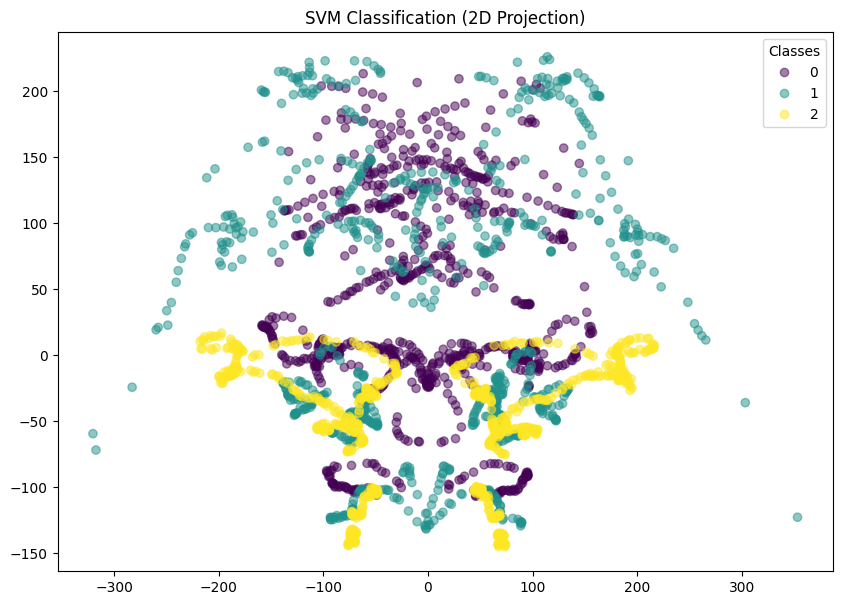

In [ ]:
svm = pca_train_svm(653)

PCA time: 2.384185791015625e-07
Time: 0.9957888126373291
369 components
Accuracy on test set: 0.6370967741935484
Classification report:
              precision    recall  f1-score   support

           0       0.59      0.54      0.56       124
           1       0.80      0.53      0.64       124
           2       0.59      0.84      0.69       124

    accuracy                           0.64       372
   macro avg       0.66      0.64      0.63       372
weighted avg       0.66      0.64      0.63       372



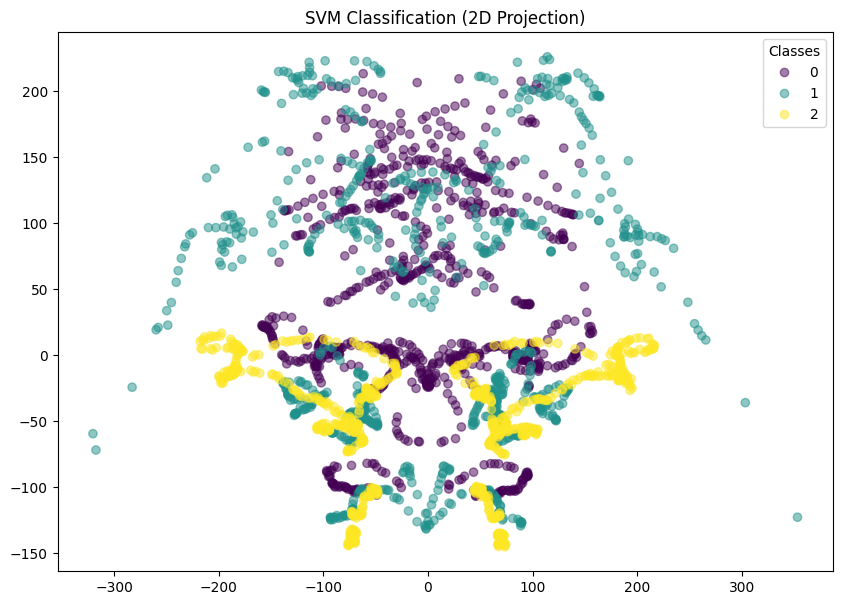

In [ ]:
svm = pca_train_svm(369)

PCA time: 4.76837158203125e-07
Time: 0.2846245765686035
213 components
Accuracy on test set: 0.6397849462365591
Classification report:
              precision    recall  f1-score   support

           0       0.59      0.52      0.56       124
           1       0.81      0.55      0.65       124
           2       0.59      0.85      0.70       124

    accuracy                           0.64       372
   macro avg       0.66      0.64      0.63       372
weighted avg       0.66      0.64      0.63       372



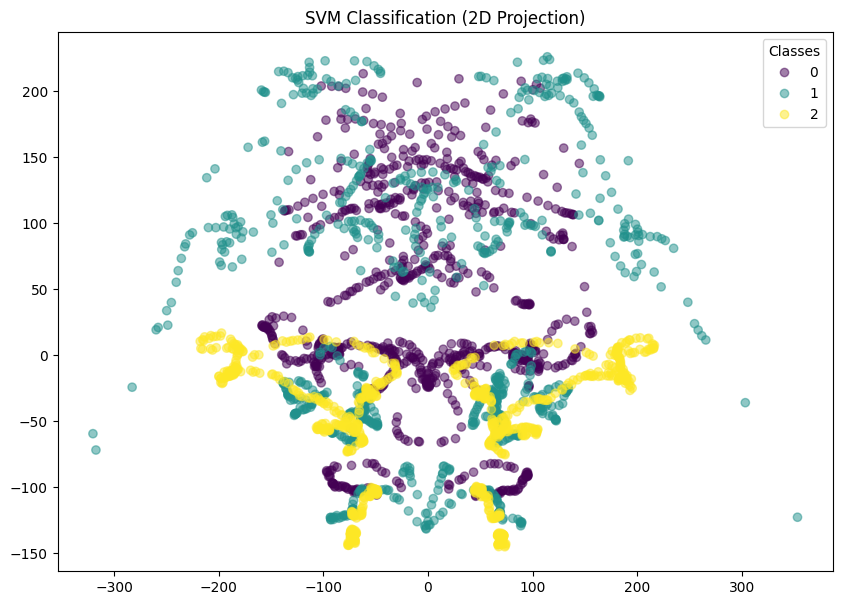

In [ ]:
svm = pca_train_svm(213)

PCA time: 7.152557373046875e-07
Time: 0.18770742416381836
106 components
Accuracy on test set: 0.6209677419354839
Classification report:
              precision    recall  f1-score   support

           0       0.51      0.50      0.50       124
           1       0.76      0.56      0.65       124
           2       0.63      0.80      0.70       124

    accuracy                           0.62       372
   macro avg       0.63      0.62      0.62       372
weighted avg       0.63      0.62      0.62       372



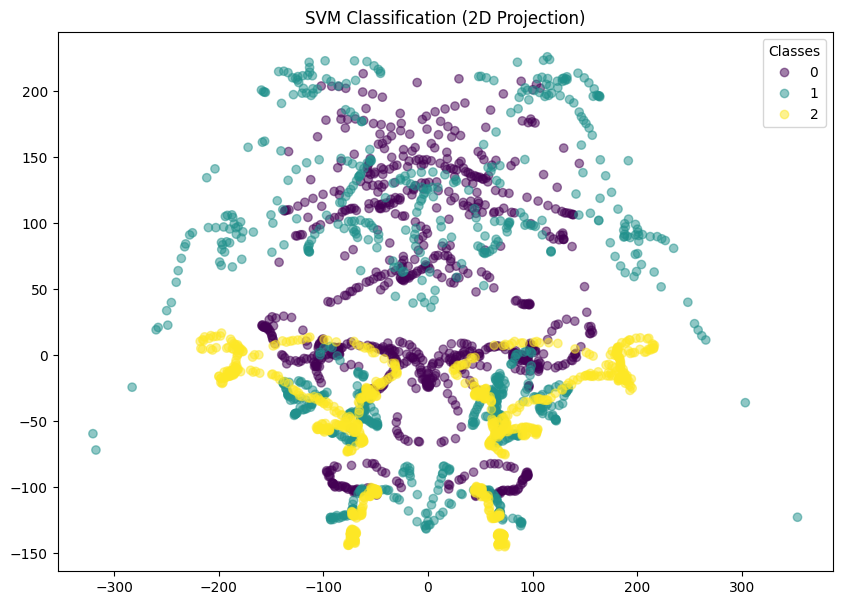

In [ ]:
svm = pca_train_svm(106)

# Neural Networks

In [ ]:
import seaborn as sns

In [ ]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, num_components=1580, hidden_layers=200):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_components, hidden_layers)  # Input layer
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_layers, hidden_layers)
        self.drop2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_layers, 3)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for the input layer
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))  # No activation function for the output layer
        x = self.drop2(x)
        x = self.fc3(x)
        return x



In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

# TODO: this is not GPU optimized

def pca_train_nn(net, num_components=1580, epochs=25):

    start = time.time()

    X_train = torch.tensor(transformed_data_1580[:, :num_components], dtype=torch.float32)
    X_val = torch.tensor(transformed_data_1580_test[:50, :num_components], dtype=torch.float32)
    X_test = torch.tensor(transformed_data_1580_test[:, :num_components])
    y_train = base_ds['train']['label']
    y_val = base_ds['test'][:50]['label']
    y_test = base_ds['test']['label']

    # Create Dataset and Dataloader
    dataset = TensorDataset(X_train, torch.tensor(y_train, dtype=torch.uint8))
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Define a loss function and an optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters())

    progress = [] # keep track of training and val loss/acc

    # Training loop
    for epoch in tqdm(range(epochs)):  # number of epochs
        train_correct = 0
        train_total = 0
        for inputs, targets in dataloader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)

            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == targets).sum().item()
            train_total += len(targets)

        # Print loss for every epoch
        # print(f"Epoch {epoch+1}, Loss: {loss.item()}")

        # quick validation
        with torch.no_grad():
            _, val_pred = torch.max(net(X_val), 1)
            val_acc = accuracy_score(y_val, val_pred)
        progress.append((loss.item(), train_correct / train_total, val_acc))

    # train_test_split(transformed_data_base_set, ds_shuffled['train']['label'], test_size=0.2, random_state=42)

    # # Create and train the SVM classifier
    with torch.no_grad():
        _, y_pred = torch.max(net(X_test), 1)

    end = time.time()
    print(f"Time: {end - start}")
    # # Evaluate the classifier
    print(f"{num_components} components")
    print("Accuracy on test set:", accuracy_score(y_test, y_pred))
    print("Classification report:")
    print(classification_report(y_test, y_pred))

    # pca_for_plotting = PCA(n_components=2)
    # X_train_2d = pca_for_plotting.fit_transform(X_train)

    # plt.figure(figsize=(10, 7))
    # scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, alpha=0.5)
    # plt.title("SVM Classification (2D Projection)")
    # plt.legend(*scatter.legend_elements(), title="Classes")
    # plt.show()

    return net, progress





In [ ]:
# Create an instance of the network
net = Net(num_components=1580, hidden_layers=200)

In [ ]:
_, progress = pca_train_nn(net, 1580, epochs=75)

100%|██████████| 75/75 [00:43<00:00,  1.73it/s]

Time: 43.723090410232544
1580 components
Accuracy on test set: 0.6236559139784946
Classification report:
              precision    recall  f1-score   support

           0       0.52      0.80      0.63       124
           1       0.83      0.51      0.63       124
           2       0.65      0.56      0.61       124

    accuracy                           0.62       372
   macro avg       0.67      0.62      0.62       372
weighted avg       0.67      0.62      0.62       372



<Axes: >

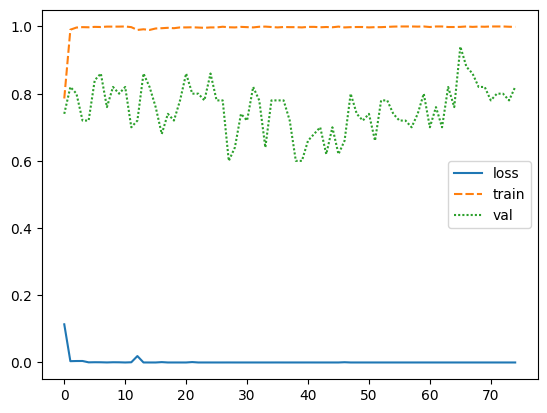

In [ ]:
df = pd.DataFrame(progress, columns=['loss','train','val'])
sns.lineplot(df)

In [ ]:
# Create an instance of the network
net = Net(num_components=653, hidden_layers=200)
_, progress = pca_train_nn(net, 653, epochs=75)

100%|██████████| 75/75 [00:25<00:00,  2.97it/s]

Time: 25.505872011184692
653 components
Accuracy on test set: 0.6854838709677419
Classification report:
              precision    recall  f1-score   support

           0       0.67      0.57      0.62       124
           1       0.83      0.64      0.72       124
           2       0.61      0.85      0.71       124

    accuracy                           0.69       372
   macro avg       0.71      0.69      0.68       372
weighted avg       0.71      0.69      0.68       372



<Axes: >

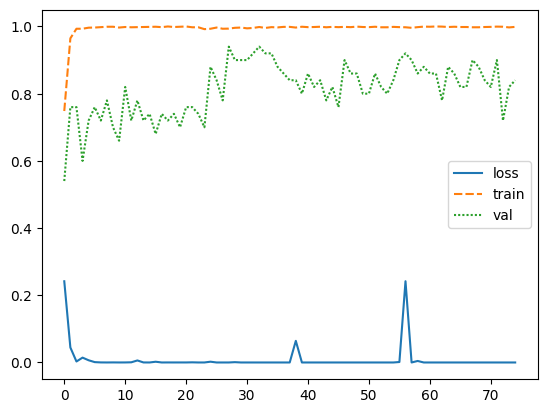

In [ ]:
df = pd.DataFrame(progress, columns=['loss','train','val'])
sns.lineplot(df)

In [ ]:
# Create an instance of the network
net = Net(num_components=369, hidden_layers=200)

In [ ]:
_, progress = pca_train_nn(net, 369, epochs=75)

100%|██████████| 75/75 [01:08<00:00,  1.09it/s]

Time: 69.33513474464417
369 components
Accuracy on test set: 0.6854838709677419
Classification report:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67       124
           1       0.92      0.48      0.63       124
           2       0.61      0.92      0.73       124

    accuracy                           0.69       372
   macro avg       0.74      0.69      0.68       372
weighted avg       0.74      0.69      0.68       372



<Axes: >

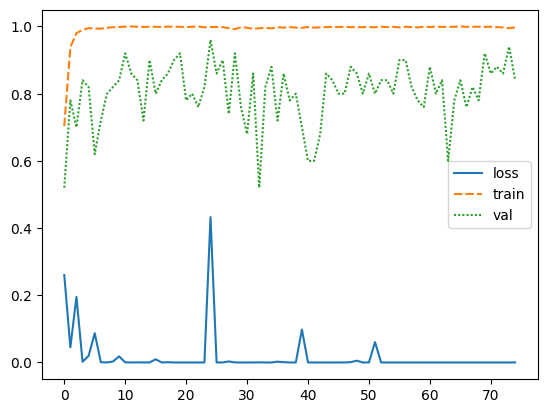

In [ ]:
df = pd.DataFrame(progress, columns=['loss','train','val'])
sns.lineplot(df)

100%|██████████| 75/75 [00:18<00:00,  4.17it/s]

Time: 18.269992113113403
213 components
Accuracy on test set: 0.6532258064516129
Classification report:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61       124
           1       0.90      0.48      0.63       124
           2       0.59      0.88      0.71       124

    accuracy                           0.65       372
   macro avg       0.70      0.65      0.65       372
weighted avg       0.70      0.65      0.65       372



<Axes: >

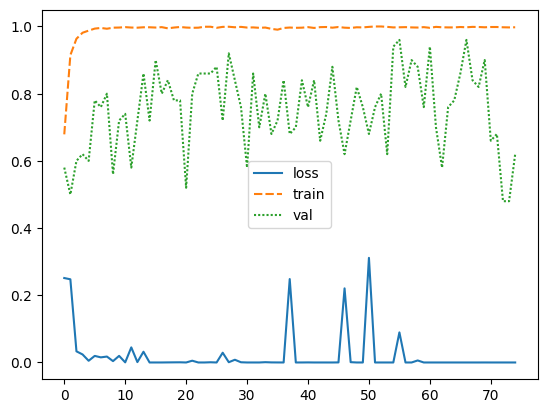

In [ ]:
# Create an instance of the network
net = Net(num_components=213, hidden_layers=200)
_, progress = pca_train_nn(net, 213, epochs=75)
df = pd.DataFrame(progress, columns=['loss','train','val'])
sns.lineplot(df)

100%|██████████| 75/75 [00:18<00:00,  4.02it/s]

Time: 19.076985120773315
106 components
Accuracy on test set: 0.7150537634408602
Classification report:
              precision    recall  f1-score   support

           0       0.69      0.73      0.71       124
           1       0.81      0.56      0.67       124
           2       0.68      0.85      0.76       124

    accuracy                           0.72       372
   macro avg       0.73      0.72      0.71       372
weighted avg       0.73      0.72      0.71       372



<Axes: >

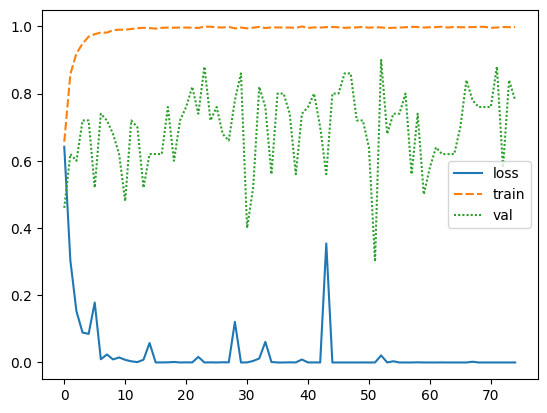

In [ ]:
# Create an instance of the network
net = Net(num_components=106, hidden_layers=200)
_, progress = pca_train_nn(net, 106, epochs=75)
df = pd.DataFrame(progress, columns=['loss','train','val'])
sns.lineplot(df)

100%|██████████| 75/75 [03:47<00:00,  3.03s/it]

Time: 227.69097995758057
653 components
Accuracy on test set: 0.706989247311828
Classification report:
              precision    recall  f1-score   support

           0       0.65      0.75      0.70       124
           1       0.87      0.53      0.66       124
           2       0.68      0.84      0.75       124

    accuracy                           0.71       372
   macro avg       0.73      0.71      0.70       372
weighted avg       0.73      0.71      0.70       372



<Axes: >

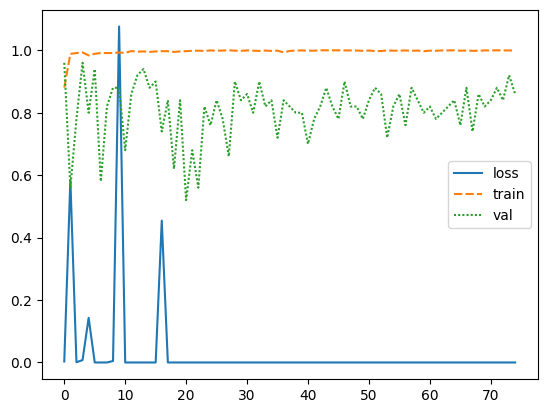

In [ ]:
# Create an instance of the network
net = Net(num_components=653, hidden_layers=1200)
_, progress = pca_train_nn(net, 653, epochs=75)
df = pd.DataFrame(progress, columns=['loss','train','val'])
sns.lineplot(df)

100%|██████████| 75/75 [00:24<00:00,  3.08it/s]

Time: 24.77583909034729
106 components
Accuracy on test set: 0.6881720430107527
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       124
           1       0.86      0.46      0.60       124
           2       0.60      0.96      0.74       124

    accuracy                           0.69       372
   macro avg       0.73      0.69      0.68       372
weighted avg       0.73      0.69      0.68       372



<Axes: >

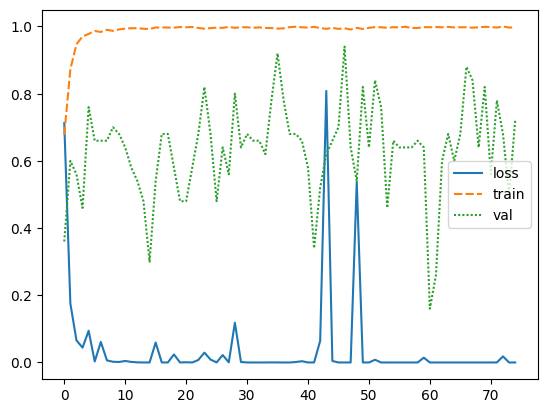

In [ ]:
# Create an instance of the network
net = Net(num_components=106, hidden_layers=300)
_, progress = pca_train_nn(net, 106, epochs=75)
df = pd.DataFrame(progress, columns=['loss','train','val'])
sns.lineplot(df)